In [1]:
import random
import os
import time
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from scipy.stats import wasserstein_distance
import matplotlib
import matplotlib.pyplot as plt
from math import isnan
from scipy.optimize import minimize
import warnings
from sklearn.neighbors import KernelDensity  # display as density curves

import torch
import torch.nn as nn
from torch.nn import init, Module, Parameter  # PyTorch syntax for optimization problems
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from geomloss import SamplesLoss

In [2]:
device = torch.device('cpu')

In [3]:
from torch.distributions.distribution import Distribution
from torch.distributions import Categorical
from torch.distributions import constraints


class MixtureSameFamily(Distribution):
    r"""
    The `MixtureSameFamily` distribution implements a (batch of) mixture
    distribution where all component are from different parameterizations of
    the same distribution type. It is parameterized by a `Categorical`
    "selecting distribution" (over `k` component) and a component
    distribution, i.e., a `Distribution` with a rightmost batch shape
    (equal to `[k]`) which indexes each (batch of) component.

    Examples::

        # Construct Gaussian Mixture Model in 1D consisting of 5 equally
        # weighted normal distributions
        >>> mix = D.Categorical(torch.ones(5,))
        >>> comp = D.Normal(torch.randn(5,), torch.rand(5,))
        >>> gmm = MixtureSameFamily(mix, comp)

        # Construct Gaussian Mixture Modle in 2D consisting of 5 equally
        # weighted bivariate normal distributions
        >>> mix = D.Categorical(torch.ones(5,))
        >>> comp = D.Independent(D.Normal(
                     torch.randn(5,2), torch.rand(5,2)), 1)
        >>> gmm = MixtureSameFamily(mix, comp)

        # Construct a batch of 3 Gaussian Mixture Models in 2D each
        # consisting of 5 random weighted bivariate normal distributions
        >>> mix = D.Categorical(torch.rand(3,5))
        >>> comp = D.Independent(D.Normal(
                    torch.randn(3,5,2), torch.rand(3,5,2)), 1)
        >>> gmm = MixtureSameFamily(mix, comp)

    Args:
        mixture_distribution: `torch.distributions.Categorical`-like
            instance. Manages the probability of selecting component.
            The number of categories must match the rightmost batch
            dimension of the `component_distribution`. Must have either
            scalar `batch_shape` or `batch_shape` matching
            `component_distribution.batch_shape[:-1]`
        component_distribution: `torch.distributions.Distribution`-like
            instance. Right-most batch dimension indexes component.
    """
    arg_constraints = {}
    has_rsample = False

    def __init__(self,
                 mixture_distribution,
                 component_distribution,
                 validate_args=None):
        self._mixture_distribution = mixture_distribution
        self._component_distribution = component_distribution

        if not isinstance(self._mixture_distribution, Categorical):
            raise ValueError(" The Mixture distribution needs to be an "
                             " instance of torch.distribtutions.Categorical")

        if not isinstance(self._component_distribution, Distribution):
            raise ValueError("The Component distribution need to be an "
                             "instance of torch.distributions.Distribution")

        # Check that batch size matches
        mdbs = self._mixture_distribution.batch_shape
        cdbs = self._component_distribution.batch_shape[:-1]
        for size1, size2 in zip(reversed(mdbs), reversed(cdbs)):
            if size1 != 1 and size2 != 1 and size1 != size2:
                raise ValueError("`mixture_distribution.batch_shape` ({0}) is not "
                                 "compatible with `component_distribution."
                                 "batch_shape`({1})".format(mdbs, cdbs))

        # Check that the number of mixture component matches
        km = self._mixture_distribution.logits.shape[-1]
        kc = self._component_distribution.batch_shape[-1]
        if km is not None and kc is not None and km != kc:
            raise ValueError("`mixture_distribution component` ({0}) does not"
                             " equal `component_distribution.batch_shape[-1]`"
                             " ({1})".format(km, kc))
        self._num_component = km

        event_shape = self._component_distribution.event_shape
        self._event_ndims = len(event_shape)
        super(MixtureSameFamily, self).__init__(batch_shape=cdbs,
                                                event_shape=event_shape,
                                                validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        batch_shape = torch.Size(batch_shape)
        batch_shape_comp = batch_shape + (self._num_component,)
        new = self._get_checked_instance(MixtureSameFamily, _instance)
        new._component_distribution = \
            self._component_distribution.expand(batch_shape_comp)
        new._mixture_distribution = \
            self._mixture_distribution.expand(batch_shape)
        new._num_component = self._num_component
        new._event_ndims = self._event_ndims
        event_shape = new._component_distribution.event_shape
        super(MixtureSameFamily, new).__init__(batch_shape=batch_shape,
                                               event_shape=event_shape,
                                               validate_args=False)
        new._validate_args = self._validate_args
        return new


    @constraints.dependent_property
    def support(self):
        # FIXME this may have the wrong shape when support contains batched 
        # parameters
        return self._component_distribution.support

    @property
    def mixture_distribution(self):
        return self._mixture_distribution

    @property
    def component_distribution(self):
        return self._component_distribution

    @property
    def mean(self):
        probs = self._pad_mixture_dimensions(self.mixture_distribution.probs)
        return torch.sum(probs * self.component_distribution.mean,
                         dim=-1 - self._event_ndims)  # [B, E]

    @property
    def variance(self):
        # Law of total variance: Var(Y) = E[Var(Y|X)] + Var(E[Y|X])
        probs = self._pad_mixture_dimensions(self.mixture_distribution.probs)
        mean_cond_var = torch.sum(probs * self.component_distribution.variance,
                                  dim=-1 - self._event_ndims)
        var_cond_mean = torch.sum(probs * (self.component_distribution.mean -
                                           self._pad(self.mean)).pow(2.0),
                                  dim=-1 - self._event_ndims)
        return mean_cond_var + var_cond_mean

    def cdf(self, x):
        x = self._pad(x)
        cdf_x = self.component_distribution.cdf(x)
        mix_prob = self.mixture_distribution.probs

        return torch.sum(cdf_x * mix_prob, dim=-1)


    def log_prob(self, x):
        x = self._pad(x)
        log_prob_x = self.component_distribution.log_prob(x)  # [S, B, k]
        log_mix_prob = torch.log_softmax(self.mixture_distribution.logits,
                                         dim=-1)  # [B, k]
        return torch.logsumexp(log_prob_x + log_mix_prob, dim=-1)  # [S, B]


    def sample(self, sample_shape=torch.Size()):
        with torch.no_grad():
            sample_len = len(sample_shape)
            batch_len = len(self.batch_shape)
            gather_dim = sample_len + batch_len
            es = self.event_shape

            # mixture samples [n, B]
            mix_sample = self.mixture_distribution.sample(sample_shape)
            mix_shape = mix_sample.shape

            # component samples [n, B, k, E]
            comp_samples = self.component_distribution.sample(sample_shape)

            # Gather along the k dimension
            mix_sample_r = mix_sample.reshape(
                mix_shape + torch.Size([1] * (len(es) + 1)))
            mix_sample_r = mix_sample_r.repeat(
                torch.Size([1] * len(mix_shape)) + torch.Size([1]) + es)

            samples = torch.gather(comp_samples, gather_dim, mix_sample_r)
            return samples.squeeze(gather_dim)


    def _pad(self, x):
        return x.unsqueeze(-1 - self._event_ndims)

    def _pad_mixture_dimensions(self, x):
        dist_batch_ndims = self.batch_shape.numel()
        cat_batch_ndims = self.mixture_distribution.batch_shape.numel()
        pad_ndims = 0 if cat_batch_ndims == 1 else \
            dist_batch_ndims - cat_batch_ndims
        xs = x.shape
        x = x.reshape(xs[:-1] + torch.Size(pad_ndims * [1]) +
                      xs[-1:] + torch.Size(self._event_ndims * [1]))
        return x

    def __repr__(self):
        args_string = '\n  {},\n  {}'.format(self.mixture_distribution,
                                             self.component_distribution)
        return 'MixtureSameFamily' + '(' + args_string + ')'

In [4]:
mix = torch.distributions.categorical.Categorical(torch.ones(5,))
comp = torch.distributions.normal.Normal(torch.randn(5,), torch.rand(5,))
gmm = MixtureSameFamily(mix, comp)

In [5]:
mix2 = torch.distributions.categorical.Categorical(torch.ones(2,))
comp2 = torch.distributions.normal.Normal(torch.randn(2,), torch.rand(2,))
gmm2 = MixtureSameFamily(mix2, comp2)


mix3 = torch.distributions.categorical.Categorical(torch.rand(3,))
comp3 = torch.distributions.normal.Normal(torch.randn(3,), torch.rand(3,))
gmm3 = MixtureSameFamily(mix3, comp3)


In [6]:
set_dist = []
for i in range(100): 
    x = torch.rand(500,1)
    set_dist.append(x)
    
for i in range(35): 
    m = torch.distributions.beta.Beta(torch.tensor([.5]), torch.tensor([.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(35): 
    m = torch.distributions.beta.Beta(torch.tensor([.7]), torch.tensor([.3]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(40): 
    m = torch.distributions.beta.Beta(torch.tensor([.2]), torch.tensor([.7]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(50): 
    m = torch.distributions.exponential.Exponential(torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(50): 
    m = torch.distributions.exponential.Exponential(torch.tensor([2.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(100): 
    m = torch.distributions.gamma.Gamma(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(40): 
    m = torch.distributions.laplace.Laplace(torch.tensor([1.0]), torch.tensor([1.5]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(59): 
    m = torch.distributions.laplace.Laplace(torch.tensor([.5]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)
    
for i in range(100): 
    m = torch.distributions.log_normal.LogNormal(torch.tensor([0.0]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)   

    
for i in range(59): 
    m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
    x = m.sample([500])
    set_dist.append(x)   

for i in range(50): 
    m = torch.distributions.normal.Normal(torch.tensor([0.3]), torch.tensor([0.5]))
    x = m.sample([500])
    set_dist.append(x)   
    
    
for i in range(100): 
    m = torch.distributions.studentT.StudentT(torch.tensor([2.0]))
    x = m.sample([500])
    set_dist.append(x) 
    
for i in range(100): 
    x = (gmm.sample([500])).view(-1,1)
    set_dist.append(x) 
    
for i in range(100): 
    x = (gmm2.sample([500])).view(-1,1)
    set_dist.append(x) 
    
for i in range(100): 
    x = (gmm3.sample([500])).view(-1,1)
    set_dist.append(x) 



    

In [7]:
set_dist = torch.stack(set_dist)

In [8]:
set_dist.shape

torch.Size([1118, 500, 1])

In [9]:
# x = torch.rand(2, 100, 1)
# y = torch.rand(2, 100, 1)
# Define a Sinkhorn (~Wasserstein) loss between sampled measures
loss = SamplesLoss(loss="sinkhorn", p=1, blur=.005)


In [10]:
class DeepSet(nn.Module):

    def __init__(self, in_features, set_features):
        super(DeepSet, self).__init__()
        self.in_features = in_features
        self.out_features = set_features
        self.feature_extractor = nn.Sequential(
            nn.Linear(in_features, 50),
            nn.ELU(inplace=True),
            nn.Linear(50, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, set_features)
        )

        self.regressor = nn.Sequential(
            nn.Linear(set_features, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Linear(30, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 2),
        )
        
        
    def forward(self, input):
        x = input
        x = self.feature_extractor(x)
        x = x.sum(dim=1)
        x = self.regressor(x)
        return x


In [11]:
class SinkhornDistance(nn.Module):
    r"""
    Given two empirical measures each with :math:`P_1` locations
    :math:`x\in\mathbb{R}^{D_1}` and :math:`P_2` locations :math:`y\in\mathbb{R}^{D_2}`,
    outputs an approximation of the regularized OT cost for point clouds.
    Args:
        eps (float): regularization coefficient
        max_iter (int): maximum number of Sinkhorn iterations
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Default: 'none'
    Shape:
        - Input: :math:`(N, P_1, D_1)`, :math:`(N, P_2, D_2)`
        - Output: :math:`(N)` or :math:`()`, depending on `reduction`
    """
    def __init__(self, eps, max_iter, reduction='none'):
        super(SinkhornDistance, self).__init__()
        self.eps = eps
        self.max_iter = max_iter
        self.reduction = reduction

    def forward(self, x, y):
        # The Sinkhorn algorithm takes as input three variables :
        C = self._cost_matrix(x, y)  # Wasserstein cost function
        x_points = x.shape[-2]
        y_points = y.shape[-2]
        if x.dim() == 2:
            batch_size = 1
        else:
            batch_size = x.shape[0]

        # both marginals are fixed with equal weights
        mu = torch.empty(batch_size, x_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / x_points).to(device).squeeze()
        nu = torch.empty(batch_size, y_points, dtype=torch.float,
                         requires_grad=False).fill_(1.0 / y_points).to(device).squeeze()

        u = torch.zeros_like(mu).to(device)
        v = torch.zeros_like(nu).to(device)
        # To check if algorithm terminates because of threshold
        # or max iterations reached
        actual_nits = 0
        # Stopping criterion
        thresh = 1e-1

        # Sinkhorn iterations
        for i in range(self.max_iter):
            u1 = u  # useful to check the update
            u = self.eps * (torch.log(mu+1e-8) - torch.logsumexp(self.M(C, u, v), dim=-1)) + u
            v = self.eps * (torch.log(nu+1e-8) - torch.logsumexp(self.M(C, u, v).transpose(-2, -1), dim=-1)) + v
            err = (u - u1).abs().sum(-1).mean()

            actual_nits += 1
            if err.item() < thresh:
                break

        U, V = u, v
        # Transport plan pi = diag(a)*K*diag(b)
        pi = torch.exp(self.M(C, U, V))
        # Sinkhorn distance
        cost = torch.sum(pi * C, dim=(-2, -1))

        if self.reduction == 'mean':
            cost = cost.mean()
        elif self.reduction == 'sum':
            cost = cost.sum()

      #  return cost, pi, C
        return cost

    def M(self, C, u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(-1) + v.unsqueeze(-2)) / self.eps

    @staticmethod
    def _cost_matrix(x, y, p=1):
        "Returns the matrix of $|x_i-y_j|^p$."
        x_col = x.unsqueeze(-2)
        y_lin = y.unsqueeze(-3)
        C = torch.sum((torch.abs(x_col - y_lin)) ** p, -1)
        return C

    @staticmethod
    def ave(u, u1, tau):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1


In [12]:
sinkhorn = SinkhornDistance(eps=0.1, max_iter=100, reduction=None).to(device)

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
           
        return x

    def __len__(self):
        return len(self.data)
    

In [14]:
dataset = MyDataset(set_dist)
loader = DataLoader(dataset, batch_size = 12, shuffle = True)

In [15]:
encoder = DeepSet(1, 36).to(device)
optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr=0.001)

# checkpoint = torch.load('autoencoder_encoder.pt')
# encoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer_encoder.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']

# # model.load_state_dict(torch.load('deepset_dist_flat1.pkl'))
# encoder.train()
# encoder.eval()

DeepSet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=50, out_features=100, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=100, out_features=36, bias=True)
  )
  (regressor): Sequential(
    (0): Linear(in_features=36, out_features=30, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): ELU(alpha=1.0, inplace=True)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [16]:
class MLPDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, set_size):
        super().__init__()
        self.output_channels = output_channels
        self.input_channels = input_channels
      
        self.set_size = set_size
        self.model = nn.Sequential(
            nn.Linear(input_channels, 10),
            nn.ELU(inplace=True),
            nn.Linear(10, 30),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(30, 30),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(30, 36),
            nn.ELU(inplace=True),
            nn.Dropout(p=.5),
            nn.Linear(36, 100),
            nn.ELU(inplace=True),
            nn.Linear(100, 256),
            nn.Dropout(p=.5),
            nn.ELU(inplace=True),
            nn.Linear(256, output_channels*set_size)
        
        )
        


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        x = x.view(x.size(0), self.set_size, self.output_channels)
        
        return x

In [17]:
decoder = MLPDecoder(2,1,500)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001, weight_decay=.001)
# checkpoint = torch.load('autoencoder_decoder.pt')
# decoder.load_state_dict(checkpoint['model_state_dict'])
# optimizer_decoder.load_state_dict(checkpoint['optimizer_state_dict'])
# loss = checkpoint['loss']

# decoder.train()


MLPDecoder(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ELU(alpha=1.0, inplace=True)
    (2): Linear(in_features=10, out_features=30, bias=True)
    (3): ELU(alpha=1.0, inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=30, out_features=30, bias=True)
    (6): ELU(alpha=1.0, inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=30, out_features=36, bias=True)
    (9): ELU(alpha=1.0, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Linear(in_features=36, out_features=100, bias=True)
    (12): ELU(alpha=1.0, inplace=True)
    (13): Linear(in_features=100, out_features=256, bias=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): ELU(alpha=1.0, inplace=True)
    (16): Linear(in_features=256, out_features=500, bias=True)
  )
)

In [18]:
def calculate_loss(batch, n_data, a, y, y_a, y_translate):
    loss = [0,0,0]
    y_norm = torch.pdist(y)
    n_data_pairwise_1 = []
    n_data_pairwise_2 = []
    for i in range(len(batch)):
        for j in range(i+1,len(batch)):
            n_data_pairwise_1.append(n_data[i])
            n_data_pairwise_2.append(n_data[j])
    n_data_pairwise_1 = torch.stack(n_data_pairwise_1)
    n_data_pairwise_2 = torch.stack(n_data_pairwise_2)
    w_norm = sinkhorn(n_data_pairwise_2, n_data_pairwise_1)
    y_a_norm = torch.pdist(y_a)
    y_translate_norm = torch.pdist(y_translate)
    loss[0] = (y_norm - w_norm).abs().sum()
    loss[1] = ((y_a_norm - a * y_norm) ** 2).sum()
    loss[2] = ((y_translate_norm - y_norm) ** 2).sum()
    loss = sum(loss)
    return loss

In [ ]:
num_epochs = 650
running_loss = []
for t in range(num_epochs):
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch.to(device), requires_grad=True)
        a = torch.rand(1).to(device)
        b = torch.rand(1).to(device)
       
    
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        y = encoder(n_data)
        y_a = encoder(a*n_data)
        y_translate = encoder(n_data + b)
        
        w = torch.empty(y.shape)
        noise = Variable(nn.init.normal_(w, mean=0.0, std=.001), requires_grad=True)
        z = decoder(y+noise)
        
       # loss_encoder = 0
        loss_decoder = 0
       
        for i in range(len(batch)):
            loss_decoder += loss(z[i], n_data[i])**2
            loss_decoder = loss_decoder/len(batch)
            
#             for j in range(i+1,len(batch)):
                
#                 y_ij = torch.norm(y[i]-y[j], p=2)
#                 w_ij = sinkhorn(n_data[i],n_data[j]) 
                
#                 ya_ij = torch.norm(y_a[i]-y_a[j], p=2)
#                 y_translate_ij = torch.norm(y_translate[i]-y_translate[j], p=2)
                
#                 diff_translate_ij = torch.norm(y_translate[i]-y[j], p=2)**2
                
    
#                 loss_encoder += torch.norm(y_ij-w_ij, p=2) + (ya_ij-a*y_ij)**2 + (y_translate_ij- y_ij)**2
                
#                 del w_ij
#         #TODO FIX THE LAST TERMS WITH PAIRWISE DISTANCES (SEE PYTORCH CODE)
        
        
        loss_encoder = calculate_loss(batch, n_data, a, y, y_a, y_translate)/(len(batch)*(len(batch)-1)/2)
    
        
        loss_batch = loss_encoder + loss_decoder
       
        loss_batch.backward()
       
        optimizer_decoder.step()
        optimizer_encoder.step()
    
        
    running_loss.append(loss_batch)
    print(loss_batch)
   
   

In [20]:
len(running_loss)

52

In [21]:
running_loss

[tensor([0.0823], grad_fn=<AddBackward0>),
 tensor([0.1545], grad_fn=<AddBackward0>),
 tensor([0.6018], grad_fn=<AddBackward0>),
 tensor([0.7524], grad_fn=<AddBackward0>),
 tensor([0.1143], grad_fn=<AddBackward0>),
 tensor([0.6857], grad_fn=<AddBackward0>),
 tensor([0.0833], grad_fn=<AddBackward0>),
 tensor([0.0891], grad_fn=<AddBackward0>),
 tensor([0.5008], grad_fn=<AddBackward0>),
 tensor([0.3427], grad_fn=<AddBackward0>),
 tensor([0.1139], grad_fn=<AddBackward0>),
 tensor([0.0571], grad_fn=<AddBackward0>),
 tensor([0.1046], grad_fn=<AddBackward0>),
 tensor([0.9911], grad_fn=<AddBackward0>),
 tensor([0.7912], grad_fn=<AddBackward0>),
 tensor([0.2586], grad_fn=<AddBackward0>),
 tensor([0.0984], grad_fn=<AddBackward0>),
 tensor([0.4491], grad_fn=<AddBackward0>),
 tensor([0.1116], grad_fn=<AddBackward0>),
 tensor([0.2526], grad_fn=<AddBackward0>),
 tensor([0.2025], grad_fn=<AddBackward0>),
 tensor([0.1162], grad_fn=<AddBackward0>),
 tensor([0.3517], grad_fn=<AddBackward0>),
 tensor([0.

In [22]:
torch.save({
    
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer_encoder.state_dict(),
            'loss': loss
            
            }, 'autoencoder_encoder.pt')

torch.save({
    
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer_decoder.state_dict(),
            'loss': loss
            
            }, 'autoencoder_decoder.pt')

In [31]:
m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
x = m.sample([500]).view(1,500,1)
y = model(x)
z = decoder(y).view(500,1)

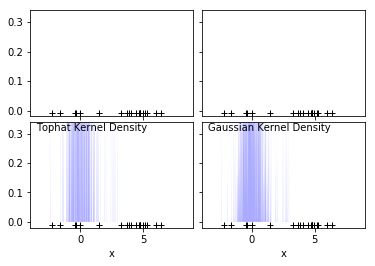

In [70]:
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
bins = np.linspace(-3, 3, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# # histogram 1
# ax[0, 0].hist(z.detach().numpy()[:, 0], bins=bins, fc='#AAAAFF', )
# ax[0, 0].text(-3.5, 0.31, "Histogram")

# # histogram 2
# ax[0, 1].hist(z.detach().numpy()[:, 0], bins=bins + 0.75, fc='#AAAAFF', )
# ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel='tophat', bandwidth=0.002).fit(zo.detach().numpy())
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.002).fit(zo.detach().numpy())
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc='#AAAAFF')
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '+k')
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

# for axi in ax[:, 0]:
#     axi.set_ylabel('Normalized Density')

for axi in ax[1, :]:
    axi.set_xlabel('x')


In [62]:
o = torch.zeros(1,500,1)
yo = model(o)
zo = decoder(yo).view(500,1)

In [60]:
torch.std(zo)

tensor(0.6218, grad_fn=<StdBackward0>)

In [67]:
m1 = torch.distributions.gamma.Gamma(torch.tensor([1.0]), torch.tensor([1.5]))
x1 = m.sample([500]).view(1,500,1)
y1 = model(x1)
z1 = decoder(y1).view(500,1)
x2 = x1.view(500,1)

In [ ]:
#More 